<a href="https://colab.research.google.com/github/cccadet/dermatologist-ai/blob/master/ISIC_2019_InceptionResNetV2_full_sensitivity_Live.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré: Conexão com Google Drive

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Etapa 1: Instalação das dependências

In [1]:
!pip install tensorflow-gpu==2
!pip install tqdm
!pip install kaggle

     |████████████████████████████████| 380.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 31.4MB/s 
     |████████████████████████████████| 450kB 69.6MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

### Importação das bibliotecas

In [2]:
import zipfile
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.0.0'

### Otimizações tensorflow

In [0]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)

### Fazendo o download da base de dados de imagens

In [4]:
if (os.path.isdir('./train')==False):
  !wget --no-check-certificate \
      https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip \
      -O ./skin_cancer_train.zip

--2020-02-03 23:35:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘./skin_cancer_train.zip’

./skin_cancer_train 100%[===================>]   5.34G  30.3MB/s    in 2m 13s  

2020-02-03 23:37:26 (41.2 MB/s) - ‘./skin_cancer_train.zip’ saved [5736557430/5736557430]



In [5]:
if (os.path.isdir('./valid')==False):
  !wget --no-check-certificate \
      https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip \
      -O ./skin_cancer_valid.zip

--2020-02-03 23:37:29--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864538487 (824M) [application/zip]
Saving to: ‘./skin_cancer_valid.zip’

./skin_cancer_valid 100%[===================>] 824.49M  33.4MB/s    in 18s     

2020-02-03 23:37:47 (46.7 MB/s) - ‘./skin_cancer_valid.zip’ saved [864538487/864538487]



In [6]:
if (os.path.isdir('./test')==False):
  !wget --no-check-certificate \
      https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip \
      -O ./skin_cancer_test.zip

--2020-02-03 23:37:54--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.128
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5528640507 (5.1G) [application/zip]
Saving to: ‘./skin_cancer_test.zip’

./skin_cancer_test. 100%[===================>]   5.15G  31.8MB/s    in 2m 10s  

2020-02-03 23:40:05 (40.4 MB/s) - ‘./skin_cancer_test.zip’ saved [5528640507/5528640507]



## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [0]:
train_dir = "./train"
validation_dir = "./valid"
test_dir = "./test"

download_path = './'
derm_ai_path = '/content/drive/My Drive/Colab Notebooks/Dermatologist_AI'
ground_truth_file = os.path.join(derm_ai_path, 'ground_truth.csv')

### Descompactando a base de dados de Treinamento

In [8]:
%%time
#dataset_path_train = "./skin_cancer_train.zip"
if (os.path.isdir('./train')==False):
  dataset_path_train = os.path.join(download_path,"skin_cancer_train.zip")
  zip_object = zipfile.ZipFile(file=dataset_path_train, mode="r")
  zip_object.extractall("./")
  zip_object.close()

CPU times: user 35.1 s, sys: 6.65 s, total: 41.8 s
Wall time: 2min 48s


### Descompactando a base de dados de Validação

In [9]:
%%time
#dataset_path_valid = "./skin_cancer_valid.zip"
if (os.path.isdir('./valid')==False):
  dataset_path_valid = os.path.join(download_path, "skin_cancer_valid.zip")
  zip_object = zipfile.ZipFile(file=dataset_path_valid, mode="r")
  zip_object.extractall("./")
  zip_object.close()

CPU times: user 5.29 s, sys: 976 ms, total: 6.27 s
Wall time: 26.5 s


### Descompactando a base de dados de Testes

In [10]:
%%time
#dataset_path_valid = "./skin_cancer_valid.zip"
if (os.path.isdir('./test')==False):
  dataset_path_test = os.path.join(download_path,"skin_cancer_test.zip")
  zip_object = zipfile.ZipFile(file=dataset_path_test, mode="r")
  zip_object.extractall("./")
  zip_object.close()

CPU times: user 31.2 s, sys: 6.34 s, total: 37.5 s
Wall time: 2min 42s


In [0]:
!rm ./skin_cancer_train.zip
!rm ./skin_cancer_valid.zip
!rm ./skin_cancer_test.zip

In [0]:
!mkdir ~/.kaggle/
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json

In [34]:
!kaggle datasets download -d seba07/tuhh-ism-test-val

100% 9.09G/9.10G [03:32<00:00, 24.2MB/s]
100% 9.10G/9.10G [03:32<00:00, 46.0MB/s]


In [0]:
%%time
#if (os.path.isdir('./test')==False):
isic_2019 = os.path.join(download_path,"tuhh-ism-test-val.zip")
zip_object = zipfile.ZipFile(file=isic_2019, mode="r")
zip_object.extractall("./")
zip_object.close()

In [0]:
!rm ./tuhh-ism-test-val.zip

AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando geradores de dados (Data Generators)

Redimensionando as imagens

    Grandes arquiteturas treinadas suportam somente alguns tamanhos pré-definidos.

Por exemplo: InceptionResNetV2 (que estamos usando) suporta: (299x299).

In [0]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=15,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    #brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                    fill_mode="constant"
)
data_gen_test = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)

In [20]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=32, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(299,299), batch_size=32, class_mode="categorical", shuffle=False)
test_generator = data_gen_test.flow_from_directory(test_dir, target_size=(299,299), batch_size=32, class_mode="categorical", shuffle=False)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


#### Exibição de 3 imagens carregadas

[0. 1. 0.]


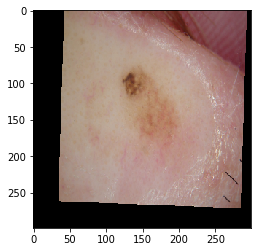

[1. 0. 0.]


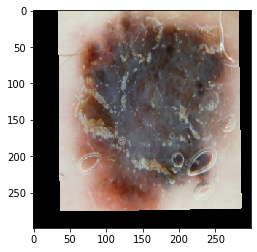

[0. 0. 1.]


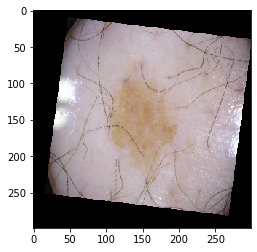

In [21]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

## Etapa 3: Construindo o modelo

### Carregando o modelo pré-treinado (InceptionResNetV2)

In [0]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.InceptionResNetV2(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

### Congelando o modelo base

In [0]:
base_model.trainable = False

### Definindo o cabeçalho personalizado da rede neural

In [0]:
#base_model.output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#global_average_layer
prediction_layer = tf.keras.layers.Dense(units = 3, activation = "softmax")(global_average_layer)

### Definindo o modelo

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)
#model.summary()

### Compilando o modelo

In [17]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.Recall(thresholds=0.2, class_id=0)])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.SpecificityAtSensitivity(1)])

TypeError: ignored

### Treinando o modelo

In [0]:
%%time
model.fit_generator(train_generator, epochs=1, validation_data=valid_generator)

63/63 [==============================] - 372s 6s/step - loss: 0.8690 - specificity_at_sensitivity: 0.0000e+00 - val_loss: 1.6021 - val_specificity_at_sensitivity: 0.0000e+00
CPU times: user 7min 19s, sys: 8.92 s, total: 7min 28s
Wall time: 6min 12s


### Avaliação do modelo de transferência de aprendizagem

In [0]:
valid_loss, valid_auc = model.evaluate_generator(valid_generator)
valid_auc

0.0

## Etapa 4: Fine tuning


Algumas questões principais:

- NEM SEMPRE é necessário realizar o Fine Tuning em toda a rede neural, pois somente em algumas camadas já é suficiente. A ideia é adotar parte específica da rede neural para nosso problema específico
- Inicie o Fine Tuning DEPOIS que você finalizou a transferência de aprendizagem. Se você tentar o Fine Tuning imediatamente, os gradientes serão muito diferentes entre o cabeçalho personalizado e algumas camadas descongeladas do modelo base 
- Mais informações em como usar o Fine Tuning acesse: 
 https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

### Descongelando algumas camadas do topo do modelo base

In [0]:
base_model.trainable = True
len(base_model.layers)

780

Descomentar trecho abaixo para manter camadas congeladas. O número informado no parâmetro `fine_tuning_at` define o número das primeiras camadas que ficarão congeladas. Supondo que a rede tenha 780 camadas e seja informado o valor 500, até a camada 500 a rede ficará congelada.

In [0]:
#fine_tuning_at = 500
#for layer in base_model.layers[:fine_tuning_at]:
#  layer.trainable = False

### Compilando o modelo para fine tuning

In [0]:
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.Recall(thresholds=0.2, class_id=0)])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.SpecificityAtSensitivity()])

### Fine tuning

In [0]:
%%time

checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.weights.best.my.hdf5')

my_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_best_only=True,
                                                 monitor='val_specificity_at_sensitivity_1',
                                                 #monitor='val_categorical_accuracy',
                                                 verbose=1)

model.fit_generator(train_generator, epochs=10, validation_data=valid_generator, callbacks=[my_checkpointer]) #10 ac 5 ss-ac

Epoch 1/10
62/63 [============================>.] - ETA: 5s - loss: 0.5815 - specificity_at_sensitivity_1: 0.0000e+00 
Epoch 00001: val_specificity_at_sensitivity_1 improved from inf to 0.00000, saving model to /content/drive/My Drive/Colab Notebooks/Dermatologist_AI/InceptionResNetV2_full_sp.weights.best.my.hdf5
63/63 [==============================] - 363s 6s/step - loss: 0.5793 - specificity_at_sensitivity_1: 0.0000e+00 - val_loss: 1.0559 - val_specificity_at_sensitivity_1: 0.0000e+00
Epoch 2/10
62/63 [============================>.] - ETA: 4s - loss: 0.5915 - specificity_at_sensitivity_1: 0.0000e+00
Epoch 00002: val_specificity_at_sensitivity_1 did not improve from 0.00000
63/63 [==============================] - 315s 5s/step - loss: 0.5921 - specificity_at_sensitivity_1: 0.0000e+00 - val_loss: 1.5533 - val_specificity_at_sensitivity_1: 0.0000e+00
Epoch 3/10
62/63 [============================>.] - ETA: 4s - loss: 0.5565 - specificity_at_sensitivity_1: 0.0000e+00
Epoch 00003: val_s

### Avaliação do modelo com fine tuning

In [0]:
valid_loss, valid_score = model.evaluate_generator(valid_generator)
valid_score

0.0

### Salvar modelo após Fine Tuning

In [0]:
%%time
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.

InceptionResNetV2_model_file = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.h5')
model.save(InceptionResNetV2_model_file) 

CPU times: user 5.03 s, sys: 689 ms, total: 5.72 s
Wall time: 6.1 s


### Carregar modelo após Fine Tuning com os melhores pesos

In [0]:
%%time

#InceptionResNetV2_model_file = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.h5')
checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.weights.best.my.hdf5')

# Recreate the exact same model, including its weights and the optimizer
#model = tf.keras.models.load_model(InceptionResNetV2_model_file)
model.load_weights(checkpoint_filepath)

# Show the model architecture
#model.summary()

CPU times: user 1.61 s, sys: 212 ms, total: 1.82 s
Wall time: 3.77 s


### Execução das predições na base de testes

In [0]:
%%time

test_generator.reset()
pred=model.predict_generator(test_generator,
                              verbose=1)

19/19 [==============================] - 229s 12s/step
CPU times: user 3min 59s, sys: 3.65 s, total: 4min 3s
Wall time: 3min 49s


### Identificar classe predita

In [0]:
def predClasses(pred, train_generator):
  predicted_class_indices=np.argmax(pred,axis=1)

  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]
  return predicted_class_indices, labels, predictions

  

### Salvar resultado para conferência

In [0]:
results_file = os.path.join(derm_ai_path, 'results_InceptionResNetV2_full_sp2.csv')

def saveResultsFile(results_file,pred, test_generator):
  filenames=test_generator.filenames
  results=pd.DataFrame({"Id":filenames,
                        "task_1":pred[:,0],
                        "task_2":pred[:,2]})
  results.to_csv(results_file,index=False)

saveResultsFile(results_file, pred, test_generator)

### Rodar avaliação do modelo em relação a base de testes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


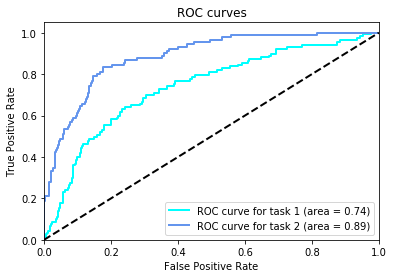

Category 1 Score: 0.738
Category 2 Score: 0.885
Category 3 Score: 0.812


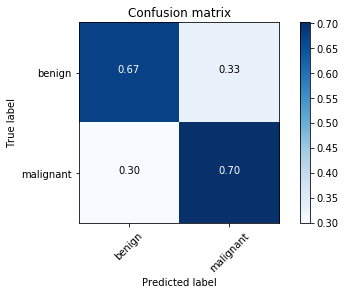

In [0]:
def testScore(results_file, threshold, ground_truth_file, derm_ai_path):
  sys.path.append(derm_ai_path)
  import get_results as results

  #threshold = 0.5

  # get ground truth labels for test dataset
  truth = pd.read_csv(ground_truth_file)
  y_true = truth.as_matrix(columns=["task_1", "task_2"])

  # get model predictions for test dataset
  y_pred = pd.read_csv(results_file)
  y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

  # plot ROC curves and print scores
  results.plot_roc_auc(y_true, y_pred)
  # plot confusion matrix
  classes = ['benign', 'malignant']
  results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)

threshold = 0.3
testScore(results_file, threshold, ground_truth_file, derm_ai_path)

### Salvar modelo com score obtido

In [0]:
InceptionResNetV2_best_model_file = os.path.join(derm_ai_path, 'InceptionResNetV2_full_t3_malig_70_sp.h5')

In [0]:
model.save(InceptionResNetV2_best_model_file) 

### Carregar melhor modelo 

In [0]:
#model = tf.keras.models.load_model(InceptionResNetV2_best_model_file)

checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.weights.best.my.hdf5')
model.load_weights(checkpoint_filepath)

## Etapa 5: Tensorflow Lite

### Converter modelo para formato tflite

In [0]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.post_training_quantize=True
tflite_model = converter.convert()

#converter.post_training_quantize=True

# Weight quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model_quantization = converter.convert()

### Salvar arquivo convertido

In [0]:
InceptionResNetV2_tflite = os.path.join(derm_ai_path, 'InceptionResNetV2_full_t3_malig_70_sp.tflite')
open(InceptionResNetV2_tflite, "wb").write(tflite_model)

217227564

### Testar modelo convertido (TFLite)
https://medium.com/towards-artificial-intelligence/testing-tensorflow-lite-image-classification-model-e9c0100d8de3

https://colab.research.google.com/github/frogermcs/TFLite-Tester/blob/master/notebooks/Testing_TFLite_model.ipynb#scrollTo=6WEyRJNsR5uL

https://aihub.cloud.google.com/p/products%2F6ca92c9c-6932-45f8-8f08-15a1a6dfafc7

In [0]:
tflite_interpreter = tf.lite.Interpreter(model_path=InceptionResNetV2_tflite)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1 299 299   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 3]
type: <class 'numpy.float32'>


In [0]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 299, 299, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 3))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

== Input details ==
shape: [ 32 299 299   3]

== Output details ==
shape: [32  3]


In [0]:
test_generator.reset()
#pred=model.predict_generator(test_generator,verbose=1)

In [0]:
test_image_batch, test_label_batch = next(iter(test_generator))
true_label_ids = np.argmax(test_label_batch, axis=-1)

print("Validation batch shape:", test_image_batch.shape)

Validation batch shape: (32, 299, 299, 3)


In [0]:
tflite_interpreter.set_tensor(input_details[0]['index'], test_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 3)


In [0]:
tflite_model_predictions

In [0]:
results_file_tflite = os.path.join(derm_ai_path, 'results_tflite_InceptionResNetV2_full_sp.csv')

saveResultsFile(results_file_tflite, tflite_model_predictions, test_generator)

ValueError: ignored